<a href="https://colab.research.google.com/github/phycem/Quantum-Machine-Learning-/blob/main/Barren_plateaus_in_quantum_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Exploring the barren plateau problem with PennyLane



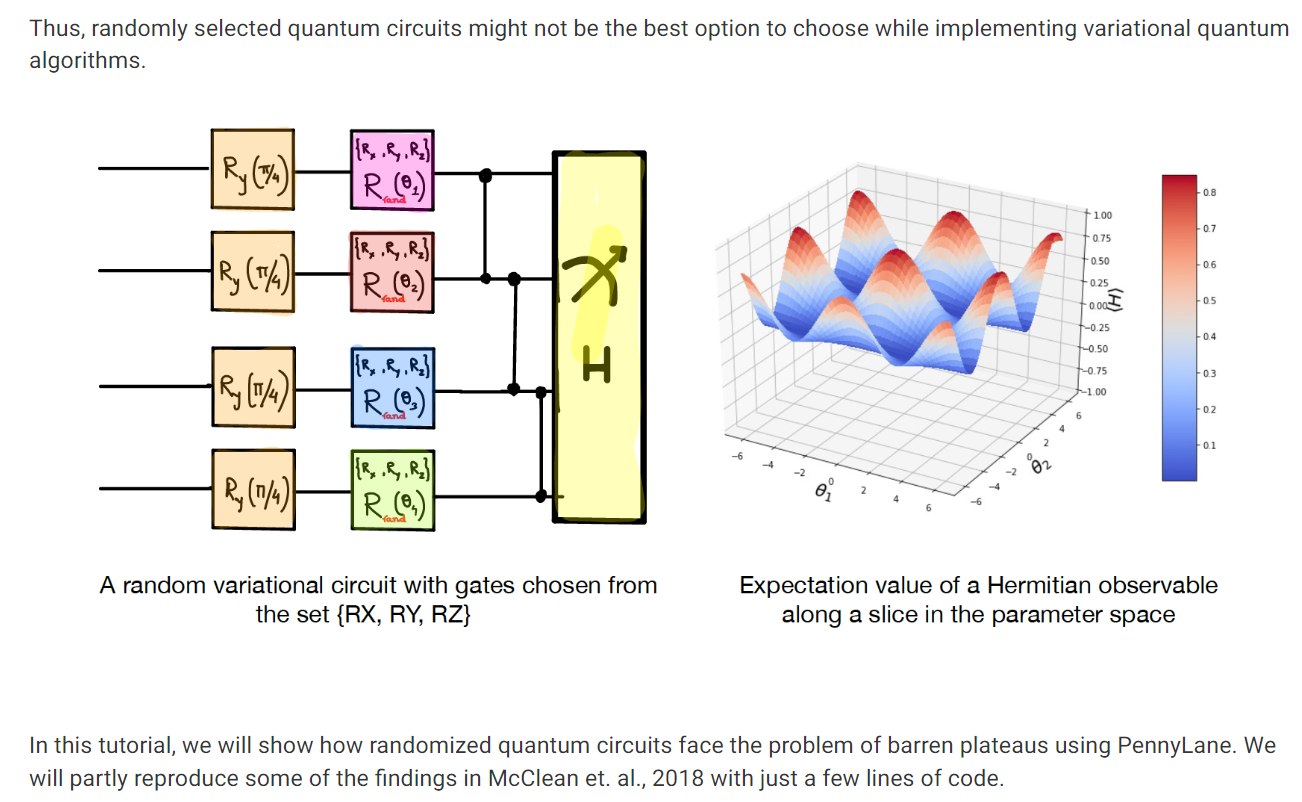


https://pennylane.ai/qml/demos/tutorial_barren_plateaus.html

In [ ]:
!pip install pennylane


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 58.2 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Set a seed for reproducibility
np.random.seed(42)

num_qubits = 4
dev = qml.device("default.qubit", wires=num_qubits)
gate_set = [qml.RX, qml.RY, qml.RZ]


def rand_circuit(params, random_gate_sequence=None, num_qubits=None):
    """A random variational quantum circuit.

    Args:
        params (array[float]): array of parameters
        random_gate_sequence (dict): a dictionary of random gates
        num_qubits (int): the number of qubits in the circuit

    Returns:
        float: the expectation value of the target observable
    """
    for i in range(num_qubits):
        qml.RY(np.pi / 4, wires=i)

    for i in range(num_qubits):
        random_gate_sequence[i](params[i], wires=i)

    for i in range(num_qubits - 1):
        qml.CZ(wires=[i, i + 1])

    H = np.zeros((2 ** num_qubits, 2 ** num_qubits))
    H[0, 0] = 1
    wirelist = [i for i in range(num_qubits)]
    return qml.expval(qml.Hermitian(H, wirelist))

In [ ]:
#compute the gradient and calculate the variance
grad_vals = []
num_samples = 200

for i in range(num_samples):
    gate_sequence = {i: np.random.choice(gate_set) for i in range(num_qubits)}
    qcircuit = qml.QNode(rand_circuit, dev, interface="autograd")
    grad = qml.grad(qcircuit, argnum=0)
    params = np.random.uniform(0, 2 * np.pi, size=num_qubits)
    gradient = grad(params, random_gate_sequence=gate_sequence, num_qubits=num_qubits)
    grad_vals.append(gradient[-1])

print("Variance of the gradients for {} random circuits: {}".format(
    num_samples, np.var(grad_vals)
    )
)
print("Mean of the gradients for {} random circuits: {}".format(
    num_samples, np.mean(grad_vals)
    )
)

Variance of the gradients for 200 random circuits: 0.0056815136930815045
Mean of the gradients for 200 random circuits: -0.0010002268976521344


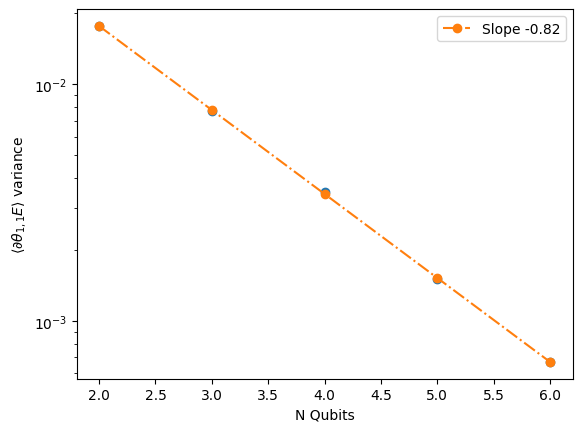

In [ ]:
#Evaluate the gradient for more qubits
qubits = [2, 3, 4, 5, 6]
variances = []


for num_qubits in qubits:
    grad_vals = []
    for i in range(num_samples):
        dev = qml.device("default.qubit", wires=num_qubits)
        qcircuit = qml.QNode(rand_circuit, dev, interface="autograd")
        grad = qml.grad(qcircuit, argnum=0)

        gate_set = [qml.RX, qml.RY, qml.RZ]
        random_gate_sequence = {i: np.random.choice(gate_set) for i in range(num_qubits)}

        params = np.random.uniform(0, np.pi, size=num_qubits)
        gradient = grad(
            params, random_gate_sequence=random_gate_sequence, num_qubits=num_qubits
        )
        grad_vals.append(gradient[-1])
    variances.append(np.var(grad_vals))

variances = np.array(variances)
qubits = np.array(qubits)


# Fit the semilog plot to a straight line
p = np.polyfit(qubits, np.log(variances), 1)


# Plot the straight line fit to the semilog
plt.semilogy(qubits, variances, "o")
plt.semilogy(qubits, np.exp(p[0] * qubits + p[1]), "o-.", label="Slope {:3.2f}".format(p[0]))
plt.xlabel(r"N Qubits")
plt.ylabel(r"$\langle \partial \theta_{1, 1} E\rangle$ variance")
plt.legend()
plt.show()

# References

## Dauphin, Yann N., et al., Identifying and attacking the saddle point problem in high-dimensional non-convex optimization. Advances in Neural Information Processing systems (2014).

## McClean, Jarrod R., et al., Barren plateaus in quantum neural network training landscapes. Nature communications 9.1 (2018): 4812.

## Grant, Edward, et al. An initialization strategy for addressing barren plateaus in parametrized quantum circuits. arXiv preprint arXiv:1903.05076 (2019).